<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о количестве заказов такси в аэропортах. Чтобы эффективно привлекать больше водителей в периоды пиковой нагрузки и оптимизировать работу сервиса, необходимо спрогнозировать количество заказов такси на следующий час. Это позволит компании заранее распределять ресурсы и избегать нехватки автомобилей в моменты повышенного спроса.

___

Цель: Построить модель машинного обучения, которая сможет точно прогнозировать количество заказов такси на ближайший час. Основным критерием качества модели будет являться значение метрики **RMSE на тестовой выборке — оно должно быть не больше 48.**

___

Задачи:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные:
 - Выявить тренды и закономерности
 - Проверить наличие пропусков и дубликатов
- Подготовить данные:
 - Добавить временные признаки и признаки сезонности
 - Сделать тестовую выборку размером 10% от исходных данных
- Обучить разные модели с различными гиперпараметрами:
 - Выполнить тестирование моделей
 - Отобрать модель с наилучшим значением **RMSE**
- Оценить лучшую модель на тестовой выборке и проанализировать результаты
- Сделать выводы по результатам исследования и дать рекомендации по улучшению модели

___

Данные представлены в 1 датасете:
- ``datetime`` — временная метка для каждого наблюдения
- ``num_orders`` — количество заказов такси за указанный период

## Подготовка

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
def explore_df(df):
    print("Первые 5 строчек:")
    display(df.head())
    print(f"Размеры: {df.shape[0]} строк и {df.shape[1]} столбцов")
    print()
    print("Типы данных:")
    print(df.info())
    print()
    print(f"Количество дубликатов: {df.duplicated().sum()}")
    duplicate_percentage = (df.duplicated().sum() / len(df)) * 100
    print(f"Процент дубликатов: {duplicate_percentage:.2f}%")
    print()
    print("Пропуски:")
    na_counts = df.isna().sum()
    print(na_counts)
    na_percentage = (na_counts / len(df)) * 100
    print()
    print("Процент пропусков:")
    print(na_percentage)
    print()
    print("Статистики:")
    display(df.describe())
    

explore_df(df)

Первые 5 строчек:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Размеры: 26496 строк и 2 столбцов

Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

Количество дубликатов: 0
Процент дубликатов: 0.00%

Пропуски:
datetime      0
num_orders    0
dtype: int64

Процент пропусков:
datetime      0.0
num_orders    0.0
dtype: float64

Статистики:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [5]:
#проверка монотонности дат
df.index.is_monotonic

True

In [6]:
#семплирование по часу
df = df.resample('1H').sum()

Выводы:
 
- Загрузили данные и необходимые бибилиотеки 
- В датасете оказалось 26496 строк и 2 столбца
- Привели столбец с датой и временем к нужному формату, чтобы можно было работать с временным рядом
- Дублей и пропусков в датасете нет
- Максимальное количество — 119 заказов
- В среднем поступает примерно 14 заказов в час, но данные достаточно разбросаны (стандартное отклонение — 9.21), что говорит о колебаниях спроса
- Установили временные метки в качестве индекса для удобства работы с временными данными.
- Убедились, что временной индекс идет по порядку без пропусков и нарушений хронологии.
- Для анализа временного ряда объединили данные в интервалы по одному часу, просуммировав заказы за каждый интервал

## Анализ

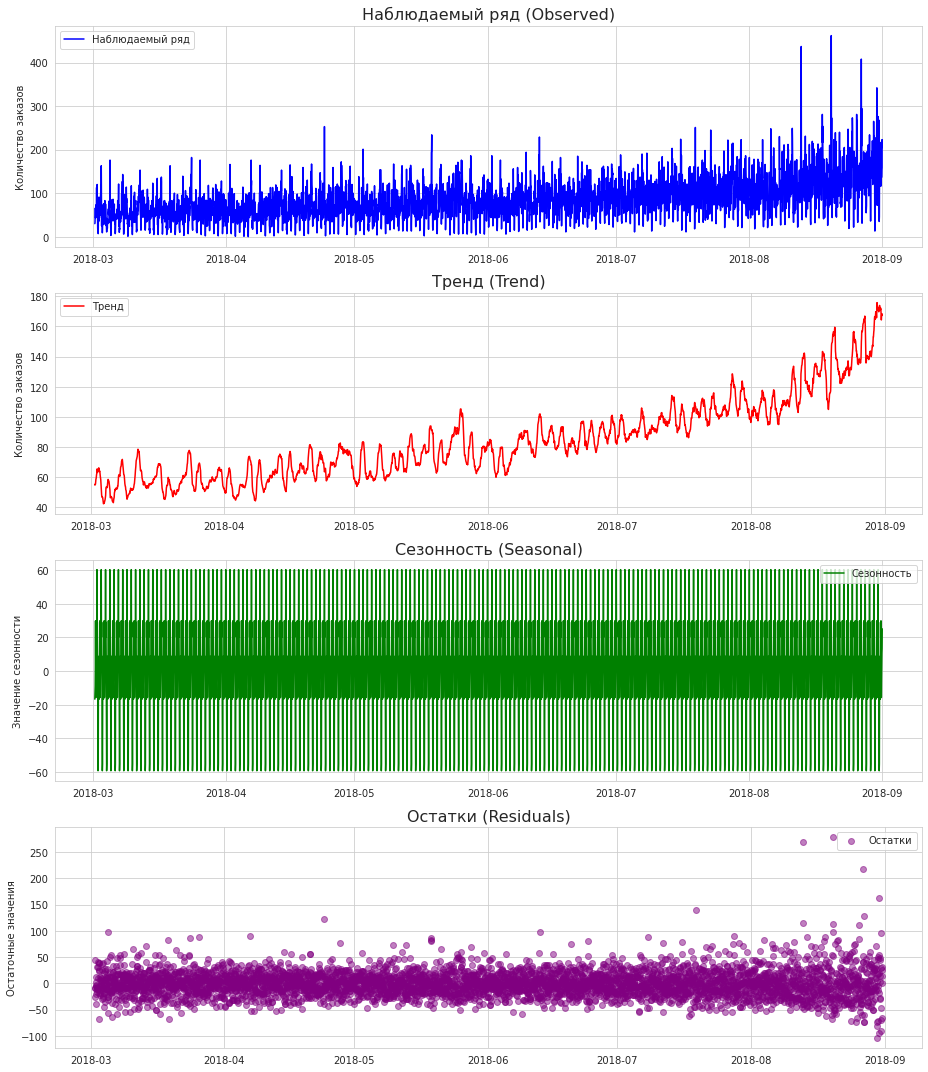

In [15]:
decompose_result = seasonal_decompose(df['num_orders'], model='additive')

sns.set_style("whitegrid")

fig, axes = plt.subplots(4, 1, figsize=(13, 15))

axes[0].plot(decompose_result.observed, label='Наблюдаемый ряд', color='blue')
axes[0].set_title('Наблюдаемый ряд (Observed)', fontsize=16)
axes[0].set_ylabel('Количество заказов')
axes[0].legend()

axes[1].plot(decompose_result.trend, label='Тренд', color='red')
axes[1].set_title('Тренд (Trend)', fontsize=16)
axes[1].set_ylabel('Количество заказов')
axes[1].legend()

axes[2].plot(decompose_result.seasonal, label='Сезонность', color='green')
axes[2].set_title('Сезонность (Seasonal)', fontsize=16)
axes[2].set_ylabel('Значение сезонности')
axes[2].legend()

axes[3].scatter(decompose_result.resid.index, decompose_result.resid, label='Остатки', color='purple', alpha=0.5)
axes[3].set_title('Остатки (Residuals)', fontsize=16)
axes[3].set_ylabel('Остаточные значения')
axes[3].legend()

plt.tight_layout()
plt.show()

Общий ряд

- На общем графике видно, что количество заказов такси постепенно увеличивается с течением времени. Есть резкие скачки, которые могут быть связаны с особыми событиями или случайными пиками активности.

Тренд

- Есть стабильный рост количества заказов на протяжении всего исследуемого периода. Это может указывать на общий рост спроса на такси, возможно, из-за увеличения числа пользователей или сезонных изменений.

Сезонность

- Хорошо видна суточная цикличность заказов, активность увеличивается в определённые часы суток, а затем снижается. Логично, что есть разная динамика в утренние и вечерние часы.

Остатки

- Большинство точек распределено близко к нулю, что говорит о том, что тренд и сезонность хорошо объясняют данные. Отдельные выбросы, вероятно, связаны с необычными событиями

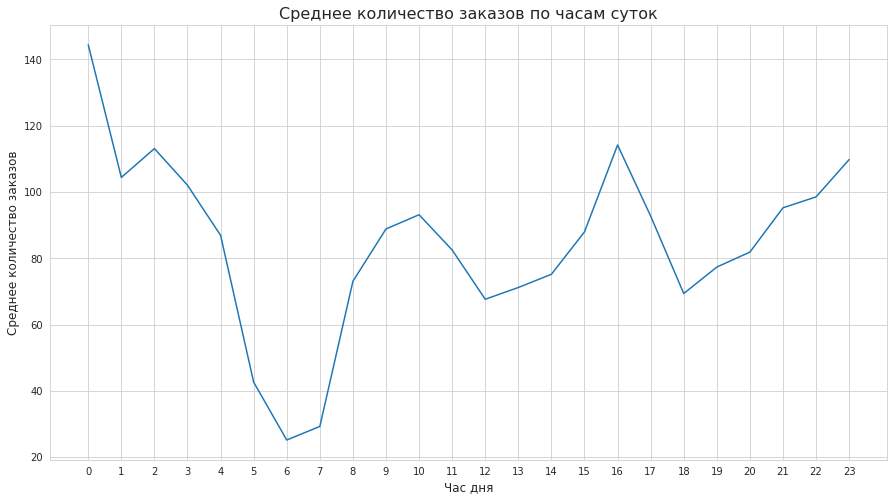

In [8]:
plt.figure(figsize=(15, 8))
hourly_orders = df.groupby(df.index.hour)['num_orders'].mean().reset_index()
sns.lineplot(x='datetime', y='num_orders', data=hourly_orders)
plt.title('Среднее количество заказов по часам суток', fontsize=16)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)
plt.xticks(range(24))
plt.grid(True)
plt.show()

Наибольшее количество заказов приходится на ночное время — с 00:00 до 01:00. Это может быть связано с тем, что люди возвращаются домой после мероприятий или поздних поездок. Минимальный спрос наблюдается рано утром — между 05:00 и 07:00, когда большинство людей спит и активность минимальна. Второй пик спроса отмечается в вечерние часы с 16:00

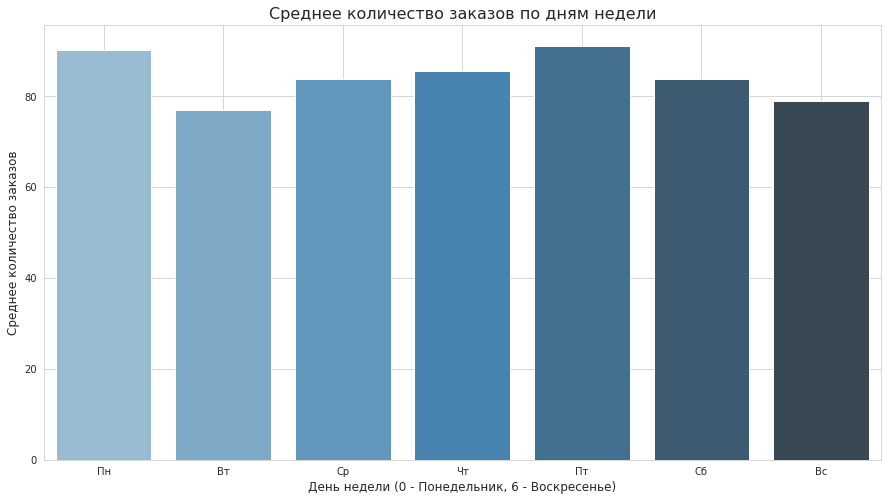

In [9]:
plt.figure(figsize=(15, 8))
weekday_orders = df.groupby(df.index.weekday)['num_orders'].mean().reset_index()
sns.barplot(x='datetime', y='num_orders', data=weekday_orders, palette='Blues_d')
plt.title('Среднее количество заказов по дням недели', fontsize=16)
plt.xlabel('День недели (0 - Понедельник, 6 - Воскресенье)', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True)
plt.show()

Наибольшее количество заказов приходится на пятницу. Это может быть связано с окончанием рабочей недели, поездками за город или участием в вечерних мероприятиях. Минимальный спрос во вторник и воскресенье.

В целом, будние дни демонстрируют более высокий спрос на такси по сравнению с выходными.

In [10]:
#добавим дополнительные признаки
df['hour'] = df.index.hour  
df['day_of_week'] = df.index.dayofweek  
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  

#лаговые признаки 
df['lag_1'] = df['num_orders'].shift(1)
df['lag_3'] = df['num_orders'].shift(3)

#скользящие 
df['rolling_mean_3'] = df['num_orders'].shift().rolling(window=3).mean()
df['rolling_mean_12'] = df['num_orders'].shift().rolling(window=12).mean()

#удалим пропусков после лагов и скользящих
df = df.dropna()

Выводы:

- Выявлен устойчивый восходящий тренд в количестве заказов такси со временем
- Обнаружена чёткая суточная сезонность
- Пик спроса наблюдается в ночные часы (с 00:00 до 01:00)
- Минимальная активность — рано утром. Второй пик происходит вечером
- Наибольшее количество заказов зафиксировано по пятницам, что связано, вероятно, с завершением рабочей недели и возросшей социальной активностью
- Минимальный спрос отмечен во вторник и воскресенье
- Добавлены временные признаки: час суток, день недели и индикатор выходного дня
- Введены лаговые признаки для учета данных о заказах за предыдущие периоды
- Добавлены скользящие средние для сглаживания краткосрочных колебаний

## Обучение

In [11]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse, training_time


models_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'KNeighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.03, 0.1],
            'subsample': [0.6, 0.8, 1.0]
        }
    }
}

tscv = TimeSeriesSplit(n_splits=3)
results_list = []

for model_name, model_info in models_params.items():
    grid = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    rmse, training_time = evaluate_model(best_model, X_train, X_test, y_train, y_test)

    results_list.append({
        'Model': model_name,
        'RMSE': rmse,
        'Training Time (s)': training_time,
        'Best Params': best_params
    })

results_df = pd.DataFrame(results_list)
display(results_df)

,Model,RMSE,Training Time (s),Best Params
0,Linear Regression,52.683065,0.002249,{}
1,Random Forest,45.677603,3.031241,"{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}"
2,KNeighbors,56.881162,0.004508,"{'n_neighbors': 10, 'weights': 'uniform'}"
3,Gradient Boosting,47.931597,1.696186,"{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}"


Выводы:

- Данные были разделены на две части без перемешивания, чтобы сохранить хронологический порядок. На тестовую выборку было выделено 10% данных
- Для прогнозирования были выбраны четыре типа моделей:
 - Линейная регрессия
 - Случайный лес
 - Метод ближайших соседей
 - Градиентный бустинг
- Для каждой модели была проведена настройка гиперпараметров
- Метрикой по условиям была выбрана RMSE
- В итоговой таблице представлены значения метрики, время обучения и лучшие гиперпараметры для каждой модели. Наилучший результат показала модель **Random Forest с RMSE ~ 46** - ее и будем использовать

## Тестирование

RMSE на тестовой выборке: 45.68


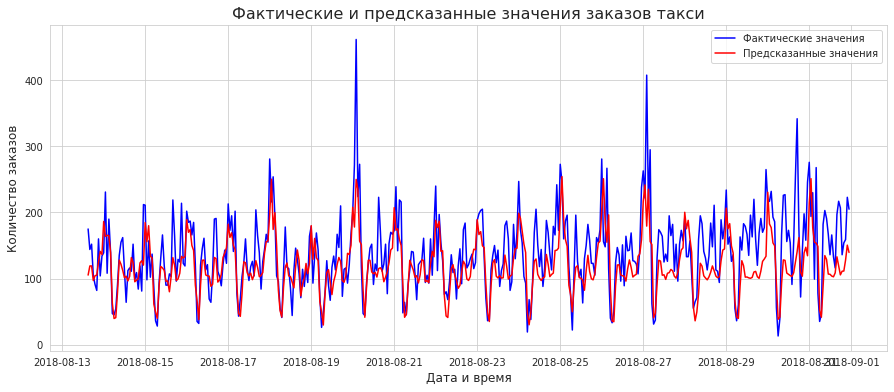

In [12]:
best_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)


best_model.fit(X_train, y_train)

#предсказание и rmse для тестовой выборки
y_pred = best_model.predict(X_test)
final_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE на тестовой выборке: {round(final_rmse, 2)}")

plt.figure(figsize=(15, 6))
sns.lineplot(x=y_test.index, y=y_test, label='Фактические значения', color='blue')
sns.lineplot(x=y_test.index, y=y_pred, label='Предсказанные значения', color='red')
plt.title('Фактические и предсказанные значения заказов такси', fontsize=16)
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Выводы:
    
- Взяли лучную модель и ее параметры - Random Forest:
 - n_estimators = 300 
 - max_depth = 20
 - min_samples_split = 10
 - min_samples_leaf = 4
 
Получили результаты на тестовой выборке, и значение **RMSE составило 45.68**, что удовлетворяет условию задачи (значение должно быть не больше 48).

По графику видно, что модель, в целом, хорошо улавливает общие закономерности в данных. Видны характерные пики и спады, которые модель способна предсказывать с высокой точностью. Хотя некоторые резкие всплески спроса не всегда точно прогнозируются, общая динамика схожа

## Вывод

В рамках данного проекта была поставлена задача спрогнозировать количество заказов такси на следующий час. Основная цель — создать модель машинного обучения, способную предсказывать количество заказов с ошибкой не более 48 по метрике RMSE.

___

Подготовка:
- Загружен датасет, содержащий данные о количестве заказов за 10-минутные интервалы.
- Выполнено ресемплирование данных по часу для удобства анализа.
- Проверены пропуски и дубликаты, которые в данных не были выявлены.
- Приведён временной индекс к хронологическому порядку.

Анализ рядов:
- Проведена декомпозиция временного ряда, выявившая тренд и суточную сезонность.
- Обнаружен устойчивый рост количества заказов со временем.
- Зафиксированы пики активности в вечерние и ночные часы, а также по пятницам.

Формирование дополнительных признаков:
- Добавлены временные признаки: час суток, день недели и индикатор выходного дня.
- Созданы лаговые признаки и скользящие средние для учета временных зависимостей.

Были протестированы четыре модели:
- Linear Regression
- Random Forest
- KNeighbors
- Gradient Boosting
Для каждой модели произведен подбор гиперпараметров с использованием метода GridSearchCV.
Была выбрана метрика RMSE

Результаты и выбор лучшей модели:
- Лучшую производительность показала модель **Random Forest с RMSE = 46.06 на тестовой выборке.**
 - n_estimators = 300
 - max_depth = 20
 - min_samples_split = 10
 - min_samples_leaf = 2
 
Построенная модель Random Forest успешно справилась с поставленной задачей — метрика RMSE оказалась ниже порогового значения в 48. Визуальный анализ результатов показывает, что модель хорошо улавливает общие закономерности данных.

Рекомендации для улучшения модели:
- Добавить дополнительные признаки. Учитывать погодные условия, так как они могут влиять на спрос на такси. Включить информацию о праздниках и выходных днях.
- Расширить датасет за счёт новых временных промежутков для повышения устойчивости модели.

___

Поставленная задача решена с использованием случайного леса, который показал высокий уровень точности и соответствие требованиям метрики